## Get monthly means from imars MODIS L3 collections in GEE

In [ ]:
# !earthengine authenticate

# NOTE: instead of running this in the notebook use the binder terminal
# 1. go to File > new > terminal
# 2. enter `earthengine authenticate` & follow prompts

In [1]:
cd /home/jovyan

/home/jovyan


In [ ]:
# check to ensure the file we need is there
!ls -lh '/home/jovyan/.config/earthengine/credentials'

#### Import EE

In [5]:
import ee
import geemap
import pandas as pd
ee.Initialize()

In [6]:
## Verify the ee module is loaded.
print(ee.__version__)

0.1.286


#### Import asset collections

Ocean Color and SST4 daily product (2002-Present) from MODIS at 1 km per pixel (FLORIDA).

OC Bands:\
b1 = Rrs 412, b2 = Rrs 443, b3 = Rrs 488, b4 = Rrs 531, b5 = Rrs 547, b6 = Rrs 667, b7 = Rrs 678, b8 = chlor a (mg/m3), b9 = nflh

SST4 Bands:\
b1 = SST (°C)

In [7]:
## Florida MODIS L3 data (uploaded from imars server)
oc = ee.ImageCollection('projects/imars-3d-wetlands/MODIS_L3/FL_OC') ## Ocean Color
sst = ee.ImageCollection('projects/imars-3d-wetlands/MODIS_L3/FL_SST4') ## SST

#### Monthly means

Define some variables first

In [8]:
band = 'b1' #Type same band in Line 149
renameBand = 'SST'
collection = sst
start_date = '2003-01-01'
end_date = '2020-12-31'

# Establish lists with months and years of selected time range above.
months = ee.List.sequence(1, 12);
years = ee.List.sequence(2003, 2020);

# Establish lists with months and years of selected time range above.
months = ee.List.sequence(1, 12);
years = ee.List.sequence(2003, 2020);

## lat/lon limits
region = ee.Geometry.Polygon([[[-86.25, 22.75], [-78.65, 22.75], [-78.65, 31.15], [-86.25, 31.15], [-86.25, 22.75]]])

## Visualization parameters
palette = ['030d81','0519ff','05e8ff','11ff01','fbff01','ff9901','ff0000','ad0000']
viz = {'min':16,'max':28,'palette':palette}

Filter collection and get monthly means:

In [9]:
## Filter collection
filtered = collection.filterDate(ee.Date(start_date), ee.Date(end_date)).select(band)

## Get monthly menas in the defined time range
byMonthYear = ee.ImageCollection.fromImages(
  years.map(lambda y: 
            months.map(lambda m:
                              filtered\
                              .filter(ee.Filter.calendarRange(y, y, 'year'))\
                              .filter(ee.Filter.calendarRange(m, m, 'month'))\
                              .reduce(ee.Reducer.mean())\
                              .set('month', m).set('year', y))).flatten())

print('Monthly Means:',byMonthYear.size().getInfo())

Monthly Means: 216


#### Visualize the first image from the collection as example

In [ ]:
# initialize our map
Map = geemap.Map()
Map.centerObject(region, 6)
Map.addLayer(byMonthYear.first(), viz, "Florida")

Map.addLayerControl()
Map

#### Get mean values from each image

In [10]:
## Function to get mean values
def getStats(img):
    ## Select and rename bands.
    #image = ee.Image(img).select(band+'_mean').rename(renameBand)
    image = ee.Image(img).rename(renameBand)
    ## Create and combine reducers of mean and std.
    reducers = ee.Reducer.mean().combine(
        reducer2= ee.Reducer.stdDev(),
        sharedInputs= True)
    ## Apply reducers to the image.
    stats = image.reduceRegion(
        reducer= reducers,
        geometry= region,
        #bestEffort= True,
        scale= 1000,
        maxPixels= 1e9)
    
    ## Create feature variable to allocate data.
    feature = ee.Feature(None)
    ## Set properties of interest.
    properties = ['system:index','month','year',renameBand+'_mean',renameBand+'_stdDev']
    ## Apply the stats on every image and collect the output.
    imageStats = image.setMulti(stats)
    ## return feature with the selected properties.
    return ee.Feature(feature).copyProperties(imageStats, properties)

In [11]:
stats = byMonthYear.map(getStats)

#### Get data in pandas format

In [26]:
year = pd.DataFrame(stats.aggregate_array('year').getInfo(), columns=['Year'])
month = pd.DataFrame(stats.aggregate_array('month').getInfo(), columns=['Month'])
mean = pd.DataFrame(stats.aggregate_array(renameBand+'_mean').getInfo(), columns=['Mean'])
std = pd.DataFrame(stats.aggregate_array(renameBand+'_stdDev').getInfo(), columns=['StdDev'])

## Concat dataframes
df = pd.concat([year, month, mean, std], axis=1)

## Insert new column with date values
df.insert(0,'Date','')
df['Date'] = df[["Year", "Month"]].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df['Date']=pd.to_datetime(df['Date'])

print(df)

          Date  Year  Month       Mean    StdDev
0   2003-01-01  2003      1  22.150675  3.488177
1   2003-02-01  2003      2  22.137196  3.599461
2   2003-03-01  2003      3  24.294582  2.470235
3   2003-04-01  2003      4  23.891055  2.102387
4   2003-05-01  2003      5  26.836783  0.870850
..         ...   ...    ...        ...       ...
211 2020-08-01  2020      8  29.699092  0.508351
212 2020-09-01  2020      9  29.201843  0.455489
213 2020-10-01  2020     10  28.101500  0.919330
214 2020-11-01  2020     11  26.275768  1.384373
215 2020-12-01  2020     12  23.826473  2.730740

[216 rows x 5 columns]


#### Plot data

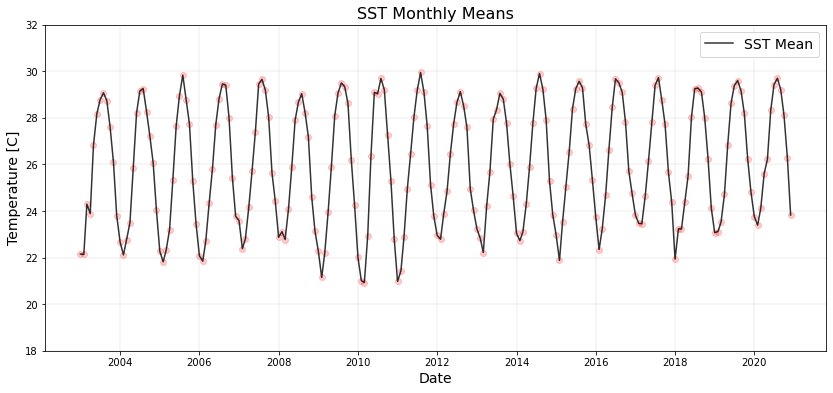

In [39]:
import matplotlib.pyplot as plt

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(df['Date'], df['Mean'],c='red',alpha=0.2)
ax.plot(df['Date'], df['Mean'],c='black',alpha=0.8,label=renameBand+' Mean')

# Add fitting curves.


# Add some parameters.
ax.set_title(renameBand+' Monthly Means', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(18, 32)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='upper right')

plt.show()

#### Save file in location

In [ ]:
## save file.....